## Méthodes d'optimisation stochastique

## I. Minimisation stochastique d'une fonction déterministe


On s'intéresse au problème $\min f(x) =\max_{i=1\dots m}|a_i^Tx-b_i | = \max_{i=1\dots m} |(Ax-b)_i|.$ 

On suppose que $a_i$ est un vecteur colonne représentant la $i$eme ligne d'une matrice $A$ de taille $m \times n$ ($m=100, n=20$) , et les $b_i$ sont les composantes d'un second membre $b$ de taille $m$, ($1 \le i \le m$), $x$ un vecteur de taille $n$. Ces quantités sont générées une fois pour toutes à partir de distributions Gaussiennes de moyenne nulle et d'écart type identité.

**Question 1 :** Constuire $A$ et $b$. Proposer le calcul d'un sous-gradient en $x$ de $f$. On pourra utiliser la fonction findmax de Julia. 


In [28]:
?findmax

ErrorException: syntax: invalid identifier name "?"

In [29]:
# Construction des données A  et b
# Insérer votre code
m = 100
n = 20
A = randn(m,n)
b = randn(m)
x = zeros(n,1)
# Fin insérer code

# Fonction calculant un sous-gradient en x de f
function subgrad(A,b,x) 
    # Insérer votre code
    f = A * x - b
    (max, ind) = findmax(abs.(f))
    #print(ind)
    argmax = ind[1]
    subg = A[argmax,:] * sign(f[argmax])
    # Fin insérer code
    return subg
end

println(subgrad(A,b,x))

[-2.325394138513605, -0.8135508034173133, -1.413787244636751, -1.1937197625175415, 1.5284097981244336, -1.607851668169735, -0.3039712614971607, 0.6700450850066538, -2.106831306739045, -0.10548362555781597, 1.6562570282676787, 0.7529151435503719, -0.14839387847899174, 0.7468074908370791, 0.1549992871186253, -0.22113614706558865, -1.1944570489236213, -0.3182583762723246, 0.3860673245705925, 1.0698463534860922]


**Question 2 :** Ce problème peut se reformuler comme un problème de programmation linéaire : $$(\mathcal{P}_{lp})\quad \left\{ \begin{array}{c} \min_{(x,R)\in \mathbb{R}^n\times \mathbb{R}} h(x,R)=R\\
s.c. \quad-R*e\leq A*x-b\leq R*e\end{array}\right.$$ avec $e=[1,\cdots,1]^T\in \mathbb{R}^m$. Résoudre le problème $(\mathcal{P}_{lp})$ en utilisant le solveur "GLPK" de la librairie JuMP. Plus d'informations sont disponibles ici :  http://www.juliaopt.org/JuMP.jl/latest/quickstart/

In [30]:
#using Pkg
#Pkg.add("JuMP"); 
#Pkg.add("GLPK")
using JuMP
using GLPK

# Définition du modèle
# Insérer votre code
model = Model(GLPK.Optimizer)
# Fin insérer code

# Définition des variables d'optimisation
# Insérer votre code
@variable(model, x[1:n])
@variable(model, R)
# Fin insérer code

# Définition de la fonctionnelle à minimiser
#Insérer votre code
@objective(model, Min, R)
# Fin insérer code

# Définition des contraintes
# Insérer votre code
for i=1:m
    @constraints model begin
        -R <= sum(A[i,j]*x[j] for j=1:n) -b[i]
        R >= sum(A[i,j]*x[j] for j=1:n) -b[i]
    end
end
# Fin insérer code

        
# Résolution        
# Insérer votre code
optimize!(model)
# Fin insérer code
        
# Résultats à optimalité                
# Insérer votre code
objective_value(model)
# println("R = ", value.(R), "\n", "x = ", value.(x))
# Fin insérer code
fstar = objective_value(model)
xstar = value.(x)
Rstar = value.(R)
println("The function value at the solution is: ",Rstar, " or ",findmax(abs.(A*xstar-b)))


The function value at the solution is: 1.4553325887368764 or (1.455332588736878, 48)


**Question 3 :** Résoudre le problème en utilisant un algorithme de sous-gradient. Dans un premier temps vous utiliserez un sous-gradient exact (Question 1), puis vous introduirez un bruit artificiel qui suit une distribution normale de moyenne nulle et d'écart-type $3 e-1$.

**Question 4 :** Vous afficherez les courbes de convergence de $f_{best}^k-f_{star}$, avec $f_{star}$ obtenue à la Question 1. Donnez la valeur minimale de $f_{best}^k-f_{star}$.

In [31]:
using Pkg
#Pkg.add("Plots")
using Plots
using LinearAlgebra

function evalf(A, b, x) 
    return findmax((abs.(A * x - b)))[1]
end

evalf (generic function with 1 method)

0.03901249071465385


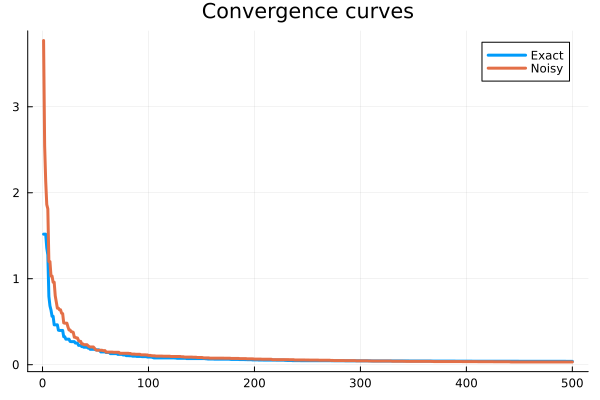

In [32]:
#Initialisation
x = zeros(n,1);
i = 0;
fbest =1e10; # $f_{best}^0$: cas du sous-gradient exact
fbestp=1e10; # $f_{best}^0$: cas du sous-gradient bruité
histo =[];# Suite des itérés f_{best}^k-f_{star} pour le cas du sous-gradient exact
histop=[];# Suite des itérés f_{best}^k-f_{star}, pour le cas du sous-gradient bruité


#Niveau de bruit
noise_lvl=.3;

# Resolution 
# Insérer votre code
#Initialisation
x = zeros(n,1);
xbest=x;
histo =[];# Suite des itérés f_{best}^k;
itermax=500;

xp = x + randn(n,1) * noise_lvl;

while i < itermax
    i = i + 1;
    # Insérer votre code
    g = subgrad(A, b, x)
    gp = subgrad(A, b, xp)

    #Définition de alpha (à modifier pour tester)
    # alpha = 1/(100*i)
    # alpha = 1/(100)
    # alpha = 1/srqt(k+1)
    # alphap = alpha
    alpha = 1/(norm(g)*i)
    alphap = 1/(norm(gp)*i)
    

    x = x - alphap * g
    #Ajout du bruit
    xp = xp - alphap * gp
    
    fbest = min(evalf(A, b, x),fbest)
    fbestp = min(evalf(A, b, xp),fbestp)

    # Stockage
    append!(histo, fbest-fstar)
    append!(histop, fbestp-fstar)
    # Fin insérer code
end
# Fin insérer code

#Affichage des courbes de convergence
iter=1:itermax;
hf=[histo,histop];
println(histo[end])
#print(histo)
#print(histop)
plot(iter,hf,title="Convergence curves",label=["Exact" "Noisy"],lw=3)

## II. Minimisation stochastique d'une fonction stochatique



On s'intéresse au problème
$$\min_x f(x) =\text{E} (\max_{i=1\dots m}|a_i^Tx-b_i |).$$

On suppose que $a_i$ est un vecteur colonne représentant la $i$eme ligne d'une matrice $A$ de taille $m \times n$ ($m=100, n=20$) , et les $b_i$ sont les composantes d'un second membre $b$ de taille $m$, ($1 \le i \le m$), $x$ un vecteur de taille $n$. Ces quantités sont générées une fois pour toutes à partir de distributions Gaussiennes de moyenne connue $\bar{A}$ et $\bar{b}$ (non nécesairement nulle) et d'écart type identité.

**Question 5 :** Proposer deux fonctions d'évaluation de la fonction $f$ et d'un sous-gradient de $f$ basées sur des échantillons de taille $M$.


In [33]:
# Evaluation de f
function fvals(Abar,bbar,noise,xs,M) 
    # Abar, bbar : moyenne des données
    # noise : niveau de bruit 
    # xs : vecteur courant 
    # M: taille de l'échantillon

# Insérer votre code
m, n = size(Abar)
esp = 0
for i = 1:M
    A_appr = Abar + noise*rand(m,n)
    b_appr = bbar + rand(m)*noise
    max = evalf(A_appr, b_appr, xs)
    esp += max
end
esp = esp/M
return esp
# Fin insérer code
end

# Evaluation d'un sous-gradient
function subgrads(Abar,bbar,noise,xs,M)
    # Abar, bbar : moyenne des données
    # noise : niveau de bruit 
    # xs : vecteur courant 
    # M: taille de l'échantillon

# Insérer votre code
m, n = size(Abar)
g = zeros(n,1)
for i = 1:M
    A_appr = Abar + noise*rand(m,n)
    b_appr = bbar + rand(m)*noise
    g = g + subgrad(A_appr, b_appr, xs)
end
g = g/M
return g
# Fin insérer code
end


subgrads (generic function with 1 method)

**Question 6 :** Comparer les courbes de convergence du problème déterministe $$ \min_x f(x) = \max_{i=1\dots m}|\text{E} (a_i)^Tx-\text{E} (b_i) |,$$ et du problème stochastique obtenu avec $M=10,100,1000$ échantillons. Donnez la valeur minimale de $f$.

**Réponse :** Plus la valeur de M augmente, plus l'on observe que la convergence pour la méthode stochastique est plus rapide que pour la méthode déterministe.
J'ai affiché la valeur minimale de f ci-dessous.

In [34]:
function convergence(M)
# Données
Abar=10*ones(m,n)+1*randn(m,n);
bbar=10*randn(m,1);

#x_0
xd = zeros(n,1); # problème déterministe
xs = xd; # problème stochastique

# Bruit et echantillon
M  = 100;
noise  = 4;

j = 0;

fbestd =1e10; # $f_{best}^0$: cas d'une résolution déterministe
fbests =1e10; # $f_{best}^0$: cas d'une résolution stochastique
histod =[]; # Suite des itérés f_{best}^k pour le cas d'une résolution déterministe
histos =[]; # Suite des itérés f_{best}^k pour le cas d'une résolution stochastique


# Insérer votre code
#Initialisation
itermax=100;
while j < itermax
    j = j + 1;
    # Insérer votre code
    gd = subgrad(Abar, bbar, xd)
    gs = subgrads(Abar,bbar,noise,xs,M)

    #Définition des alphas (à modifier pour tester)
    # alphad = 1/(100*j)
    # alphad = 1/(100)
    # alphad = 1/srqt(k+1)
    # alphas = alphad
    alphad = 1/j
    alphas = 1/j
    
    # Mise à jour des x
    xd = xd - alphad * gd
    xs = xs - alphas * gs
    
    # Maj des fbests
    fbestd = min(fvals(Abar, bbar,noise, xd, M),fbestd)
    fbests = min(fvals(Abar,bbar,noise,xs,M),fbests)
    # Stockage
    append!(histod, fbestd)
    append!(histos, fbests)
    # Fin insérer code
end
# Fin insérer code
#Affichage
iter=1:itermax;
hf=[histod,histos];
mind = minimum(histod)
mins = minimum(histos)
println("Solution pour le déterministe : ", mind)
println("Solution pour le stochastique : ", mins)
println("Le minimum est environ à : ", (mind + mins)/2)
plot(iter,hf,title="Convergence curves",label=["Deterministic" "Stochastic"],lw=3)
end

convergence (generic function with 1 method)

Solution pour le déterministe : 27.13412595487573
Solution pour le stochastique : 24.798028209514147
Le minimum est environ à : 25.96607708219494


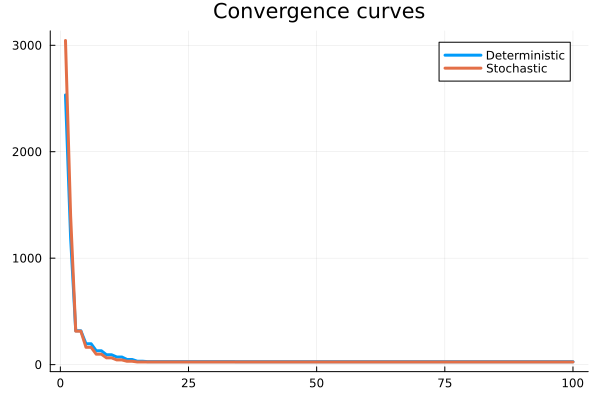

In [35]:
# Pour M = 10
convergence(10)

Solution pour le déterministe : 26.088367107085737
Solution pour le stochastique : 24.922747059033256
Le minimum est environ à : 25.505557083059497


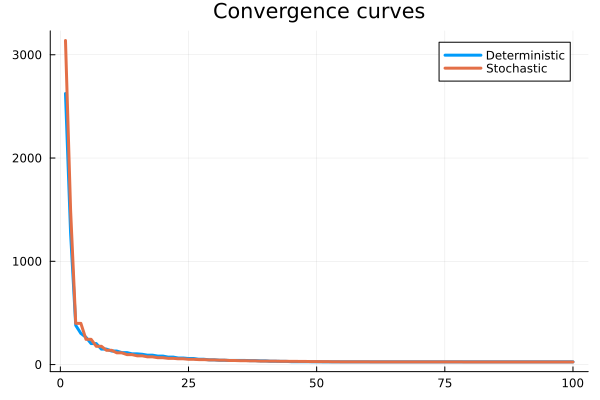

In [36]:
# Pour M = 100
convergence(100)

Solution pour le déterministe : 36.0542511310246
Solution pour le stochastique : 26.216762134703902
Le minimum est environ à : 31.13550663286425


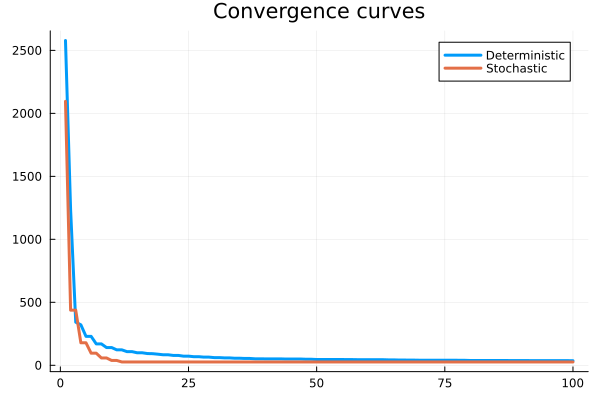

In [37]:
# Pour M = 1000
convergence(1000)

**Question 7 :** Répéter les expériences et comparer les valeurs meilleurs valeurs de f obtenues ($f_{best}$) aprs un nombre fixé d'itérations. Donnez la valeur minimale de $f_{best}$

L'écart entre les solutions stochastiques trouvées est : 1.2407157581055976
L'écart entre les solutions déterministes trouvées est : 1.1802356388925936


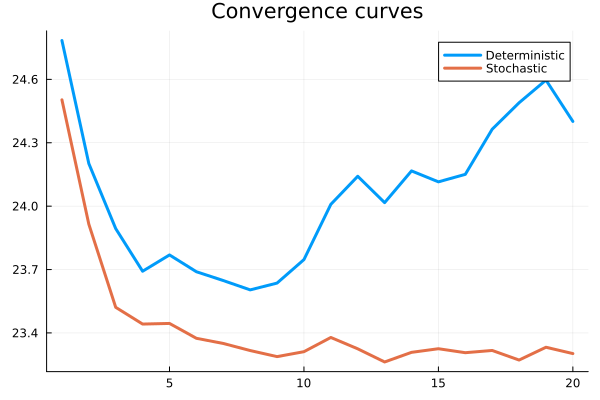

In [38]:
# Données
Abar=10*ones(m,n)+1*randn(m,n);
bbar=10*randn(m,1);

# x_0
xd = zeros(n,1); # résolution déterministe
xs = xd;  # résolution stochastique

# Bruit et echantillon
M  = 200;
noise  = 4;

#Nombre d'itérations
niter=100;


fbestd =1e10; # $f_{best}^0$: cas d'une résolution déterministe
fbests =1e10; # $f_{best}^0$: cas d'une résolution stochastique
fbesttd=[]; # f_{best} pour chaque expériences dans le cas d'une résolution déterministe
fbestts=[]; # f_{best} pour chaque expériences dans le cas d'une résolution stochastique

for nexp=1:20
    # Répétition des expériences    

# Insérer votre code
#Initialisation
j = 0;
fbestd =1e10; # $f_{best}^0$: cas d'une résolution déterministe
fbests =1e10; # $f_{best}^0$: cas d'une résolution stochastique
histod = []
histos = []

while j < niter
    j = j + 1;
    # Insérer votre code
    gd = subgrad(Abar, bbar, xd)
    gs = subgrads(Abar,bbar,noise,xs,M) 
    
    #Définition des alphas (à modifier pour tester)
    # alphad = 1/(100*j)
    # alphad = 1/(100)
    # alphad = 1/srqt(k+1)
    # alphas = alphad
    alphad = 1/(norm(gd)*j)
    alphas = 1/(norm(gs)*j)
    
    # Mise à jour des x
    xd = xd - alphad * gd
    xs = xs - alphas * gs
    
    # Maj des fbests
    fbestd = min(fvals(Abar,bbar,noise,xd,M),fbestd)
    fbests = min(fvals(Abar,bbar,noise,xs,M),fbests)
    # Stockage
    append!(histod, fbestd)
    append!(histos, fbests)
end
# Fin insérer code
#println(length(histod))
mind = minimum(histod)
mins = minimum(histos)
append!(fbesttd, mind)
append!(fbestts, mins)
# Fin insérer code
end

#Affichage
println("L'écart entre les solutions stochastiques trouvées est : ", maximum(fbestts) - minimum(fbestts))
println("L'écart entre les solutions déterministes trouvées est : ", maximum(fbesttd) - minimum(fbesttd))
iter=1:20;
hf=[fbesttd,fbestts];
plot(iter,hf,title="Convergence curves",label=["Deterministic" "Stochastic"],lw=3)

